<a href="https://colab.research.google.com/github/sivanitzhaki/AdvancedMLDLCourse-Task3/blob/main/exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Excercise 3 - Assignment III - NLP: Seinfeld or Friends?**

Sivan Itzhaki

Rotem Ecker

Mor Schenavsky

Brit Lev

In [ ]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as display_matrix
from bs4 import BeautifulSoup
import re
import nltk
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelBinarizer
from nltk.tokenize.toktok import ToktokTokenizer
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
#np.random.seed(42)
tf.random.set_seed(42)

load the data:

In [ ]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

The dataset contains information about Seinfeld and friends episodes:

In [ ]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


We can see that the text includes director remarks which we will have to handle in the preprocessing.

In [ ]:
train_df[:15]

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
5,"So, if you’re parents hadn’t got divorced, yo...",monica,Season-03 Episode-17-The One Without The Ski Trip,Friends,18
6,What's up?,ross,Season-05 Episode-18-The One Where Rachel Smokes,Friends,2
7,"(over-enthusiastic) I don't know, I don' I do...",chandler,Season-09 Episode-15-The One With The Mugging,Friends,27
8,I know. *He* always wanted to be the first bl...,chandler,Season-10 Episode-15-The One Where Estelle Dies,Friends,15
9,"This uniform, what's it made from?",george,S06E01,Seinfeld,6


Let's check if the classes are evenly distributed:

In [ ]:
train_df['Show'].value_counts()


Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

In [ ]:
test_df['Show'].value_counts()

Friends     2596
Seinfeld    1649
Name: Show, dtype: int64

We can see that the majority of characters belong to Friends (6 out of 10).

In [ ]:
print (train_df.groupby('Show')['Character'].nunique())

Show
Friends     6
Seinfeld    4
Name: Character, dtype: int64


Let's look at one example:

In [ ]:
train_df.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

# Data preprocessing

Cleaning the data

In [ ]:
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text) 

# Removing the noisy text
def clean_text(text):
    text = remove_between_square_brackets(text)
    return text

# Apply function on Dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(clean_text)
test_df['Dialogue'] = test_df['Dialogue'].apply(clean_text)

In [ ]:
train_df.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

We will remove the director's notes as they are not part of the text:

In [ ]:
# removing notes
def remove_notes(text):
  return re.sub('\(.*?\)','()', text)

# Removing the noisy text
def clean_text_notes(text):
    text = remove_notes(text)
    return text


# Apply function on Dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(clean_text_notes)
test_df['Dialogue'] = test_df['Dialogue'].apply(clean_text_notes)

In [ ]:
train_df.iloc[1,0]

' () Are you gonna be embarrassed going up there having nothing prepared?'

Let's also remove special characters:

In [ ]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on Dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(remove_special_characters)
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)

In [ ]:
train_df.iloc[1, 0]

'  Are you gonna be embarrassed going up there having nothing prepared'

Removing stop words

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print("The first 10 stopwords are: " + str(stopword_list[:10]))

Number of English stop words: 179
The first 10 stopwords are: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tokenizer = ToktokTokenizer()

In [ ]:
# Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on Dialogue column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(remove_stopwords)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)


  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

Stemming

In [ ]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_words_list = []
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
# Apply function on Dialogue column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(simple_stemmer)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

Converting all thr data to lowercase

In [ ]:
 train_df['Dialogue'] = train_df['Dialogue'].str.lower()
 test_df['Dialogue'] = test_df['Dialogue'].str.lower()


In [ ]:
train_df.iloc[1, 0]

'gonna embarrass go noth prepar'

### Train-test-valdiation split

In [ ]:
x_train = train_df['Dialogue']
y_train = train_df['Show']

x_test = test_df['Dialogue']
y_test = test_df['Show']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=1234) 

We can also check that the distribution of our labels between test and train is not skewed toward one class:

In [ ]:
train_label_count = y_train.value_counts()
test_label_count = y_test.value_counts()

print('Train negative to positive ratio:', train_label_count['Friends'] / train_label_count['Seinfeld']) 
print('Test negative to positive ratio:', test_label_count['Friends'] / test_label_count['Seinfeld']) 

Train negative to positive ratio: 1.2484630738522955
Test negative to positive ratio: 1.5742874469375379


And verify our results:

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (56324,)
y_train shape: (56324,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (14081,)
y_val shape: (14081,)


Labeling

In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

For example:

In [ ]:
y_train[:5]

array([[0],
       [0],
       [0],
       [1],
       [1]])

# **Deep Learning Model**

we're going to use Keras' tokenizer (kind of Bag of words):

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

Convert to sequences:

In [ ]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
x_test_dl = token.texts_to_sequences(x_test)

In [ ]:
x_train_dl[1]

[3132]

Calculate document length:

In [ ]:
doc_len_list = [len(doc) for doc in x_train_dl]

Exemine the distribution:

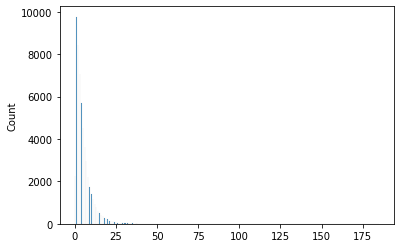

In [ ]:
sns.histplot(doc_len_list)

We want to make sure that all sequences have the same length, we will fix it to 25 based on the distribution.

In [ ]:
max_words = 25

x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = sequence.pad_sequences(x_test_dl, maxlen=max_words)

In [ ]:
x_train_dl.shape

(56324, 25)

In [ ]:
x_train_dl[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        112,  140, 2445], dtype=int32)

In [ ]:
total_words = len(token.word_index) + 1 
total_words

14966

Model architecture

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=8, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7)) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 8)             119728    
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 8)             200       
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                12864     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [ ]:
model_history=model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
881/881 [==============================] - 5s 5ms/step - loss: 0.6245 - accuracy: 0.6255 - val_loss: 0.5539 - val_accuracy: 0.7017
Epoch 2/5
881/881 [==============================] - 6s 7ms/step - loss: 0.5210 - accuracy: 0.7251 - val_loss: 0.5153 - val_accuracy: 0.7149
Epoch 3/5
881/881 [==============================] - 4s 5ms/step - loss: 0.4622 - accuracy: 0.7618 - val_loss: 0.5231 - val_accuracy: 0.7182
Epoch 4/5
881/881 [==============================] - 4s 4ms/step - loss: 0.4265 - accuracy: 0.7780 - val_loss: 0.5418 - val_accuracy: 0.7161
Epoch 5/5
881/881 [==============================] - 4s 4ms/step - loss: 0.3999 - accuracy: 0.7925 - val_loss: 0.5797 - val_accuracy: 0.7122


In [ ]:
train_accuracy = model_history.history['accuracy'][-1]
train_accuracy

0.7924508452415466

# Evaluate the model:

In [ ]:
mod_eval=model.evaluate(x_test_dl, y_test)

133/133 [==============================] - 0s 2ms/step - loss: 0.4988 - accuracy: 0.8118


## Model evaluate per actor: 
we'll do it in a loop for each of the Characters

In [ ]:
#get all the names from "Character" column and creat a list.
characters = list(train_df['Character'].unique())

print(characters)

['joey', 'phoebe', 'elaine', 'chandler', 'kramer', 'monica', 'ross', 'george', 'rachel', 'jerry']


In [ ]:
#utilty function to calculate, save and print the accuracy for each character
def character_accuracy(lst):
  accuracy_dict = {} 
  for chr in lst:
    df_chr_copy = test_df.copy()
    df_chr_copy = df_chr_copy.loc[df_chr_copy['Character'] == chr] #creating a df containing only the quotes of one character at a time
    
    #processing the data
    df_chr_test = df_chr_copy['Dialogue']
    token.fit_on_texts(df_chr_test) 
    df_chr_test = token.texts_to_sequences(df_chr_test)
    df_chr_test = sequence.pad_sequences(df_chr_test, maxlen=max_words)
    df_chr_y = lb.transform(df_chr_copy['Show'])

    #testing accuracy
    chr_accuracy = model.evaluate(df_chr_test, df_chr_y) 
    accuracy_dict[chr] = [chr_accuracy, np.round(model.predict(df_chr_test)), df_chr_y] #save the scores, predictions and labels for each character in a dictionary
  return accuracy_dict

In [ ]:
evaluate_per_chr = character_accuracy(characters)
for key in evaluate_per_chr:
  print(key + ': ' + str(evaluate_per_chr[key][0][1]))

19/19 [==============================] - 0s 2ms/step
joey: 0.7076271176338196
phoebe: 0.6979695558547974
elaine: 0.4726027250289917
chandler: 0.6909975409507751
kramer: 0.43918919563293457
monica: 0.6727748513221741
ross: 0.7157894968986511
george: 0.4113923907279968
rachel: 0.7229437232017517
jerry: 0.41737648844718933


**Results**: We can see that Phoebe and Monica have the highest accuracy score.
Jerry and Kramer got the lowest accuracy scores.

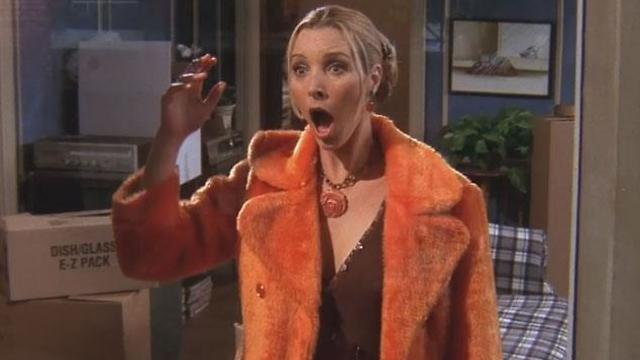

# Vizualization

Let's see what a Friends Dialogue looks like using a word cloud:

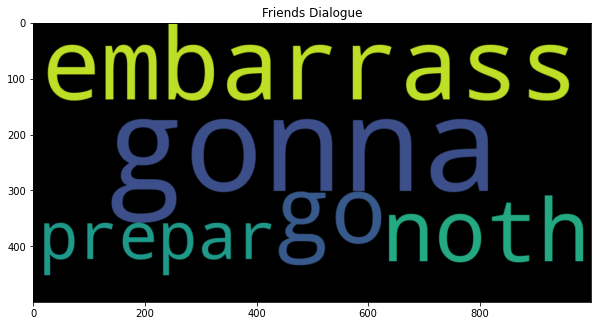

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Friends Dialogue')
friends_text = x_train[1]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
friends_words = WC.generate(friends_text)
plt.imshow(friends_words, interpolation='bilinear')
plt.show()

And what a Seinfeld Dialogue looks like using a word cloud

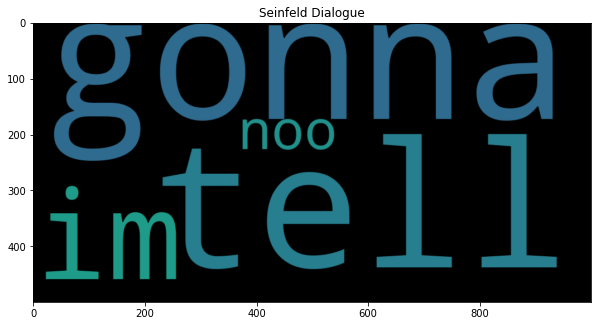

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Seinfeld Dialogue')
seinfeld_text = x_train[2]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
words = WC.generate(seinfeld_text)
plt.imshow(words, interpolation='bilinear')
plt.show()

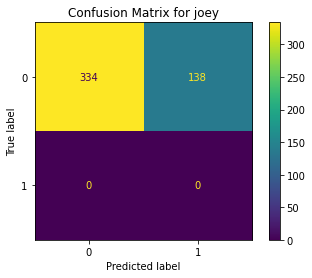

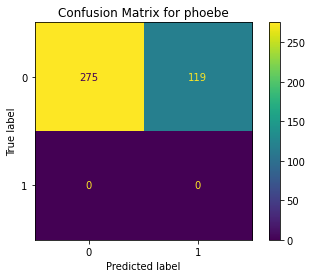

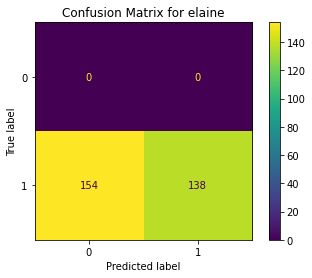

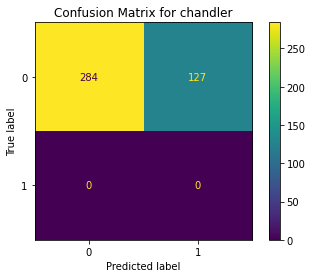

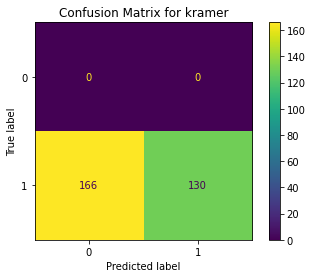

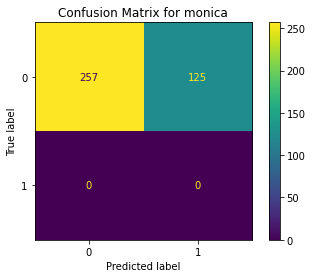

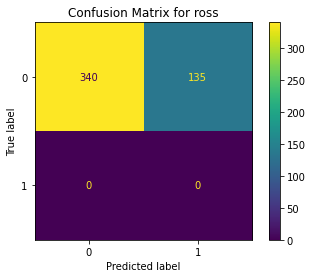

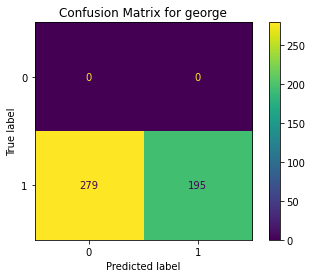

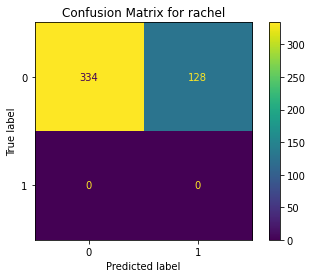

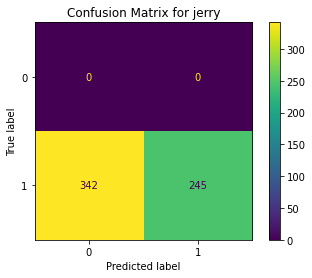

In [ ]:
for chr in characters:
  matrix = confusion_matrix(evaluate_per_chr[chr][2], evaluate_per_chr[chr][1])
  im = display_matrix(matrix)
  im.plot()
  plt.title("Confusion Matrix for " + chr)
  plt.show()

# Summary

In [ ]:
# generate the CSV file

results = {'Test score (Accuracy)': [str(mod_eval[1])],
           'Train score (Accuracy)': [str(train_accuracy)],
           'Number of trainable parameters': [134905],
           'Number of layers': [len(model.layers)],
           'Regularization methods': ['Dropout'],
           'Number of epochs': [5],
           'Loss function': ['binary_crossentropy'],
           'Optimizer': ['adam'],
           'Embedding dimension': [total_words]
           }

df = pd.DataFrame(results)
df

,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer,Embedding dimension
0,0.8117785453796387,0.7924508452415466,134905,8,Dropout,5,binary_crossentropy,adam,14966


In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))